In [1]:
import rasterio
from rasterio.plot import show
from rasterio.mask import mask

from shapely import geometry

import folium

import numpy as np
from matplotlib import pyplot as plot
import os

%matplotlib inline

In [2]:
in_dir = r"/media/ross/data01/02_data/DAR_Coastal_2015/kahoolawe"
out_dir = r"/media/ross/data01/02_data/DAR_Coastal_2015/kahoolawe_out"

In [3]:
in_file = os.path.join(in_dir, r"kahoolawe_102.tif")

In [4]:
dataset = rasterio.open(in_file)

In [ ]:
dataset

In [ ]:
print("Dataset level stats: \n")
print("bands: {}".format(dataset.count))
print("types per band: {}".format({i: dtype for i, dtype in zip(dataset.indexes, dataset.dtypes)}))
print("no data per band: {}\n".format({i: ndv for i, ndv in zip(dataset.indexes, dataset.nodatavals)}))
print("width: {}". format(dataset.width))
print("height: {}\n". format(dataset.height))
print("bounding box: {}".format(dataset.bounds))
print("affine: {}".format(dataset.transform))
print("CRS: {}".format(dataset.crs))

In [42]:
#reading in the data set as a masked array

rgb = dataset.read(masked=True)

In [62]:
#These images have more nodata values (ndv) then needed around the edges. First step is to crop it.

#this snippet is from https://github.com/mapbox/rasterio/issues/496. It rolls the 3 band values at each pixel to a single array, then checks
#the value of that array against the no data values. If any of the band values is valid, the pixel is marked as valid. 
ndvs = (1, 1, 1)
idxs = np.where(np.all(np.rollaxis(rgb, 0, 3) != ndvs, axis=2))

In [74]:
#we're going to get the min, max pixel location in each x and y

x_min = idxs[0].min() # lon
x_max = idxs[0].max()
y_min = idxs[1].min() # lat
y_max = idxs[1].max()

print('xmin: {}'.format(x_min))
print('xmax: {}'.format(x_max))
print('ymin: {}'.format(y_min))
print('ymax: {}'.format(x_max))

xmin: 9840
xmax: 15001
ymin: 2136
ymax: 15001


In [75]:
#use this method to convert pixel coordinates to image coordinates. If you're going the other way, go with dataset.index.

#(lon, lat) of top left corner
tl = dataset.xy(x_min, y_max)
#(lon, lat) of bottom left corner
bl = dataset.xy(x_min, y_min)
#(lon, lat) of top right corner
tr = dataset.xy(x_max, y_max)
#(lon, lat) of bottom right corner
br = dataset.xy(x_max, y_min)

In [77]:
#turn the corner image coordinates into a boounding box using shapely, which we can then use to clip to only the valid data.

p1 = geometry.Point(bl)
p2 = geometry.Point(br)
p3 = geometry.Point(tr)
p4 = geometry.Point(tl)

point_list = [p1, p2, p3, p4]

valid_data_polygon = geometry.Polygon([[p.x, p.y] for p in point_list])

In [82]:
#check on our polygon

valid_data_polygon.wkt

'POLYGON ((751508.3517836322 2279999.515158604, 751508.3517836322 2279896.295158604, 751765.6517836322 2279896.295158604, 751765.6517836322 2279999.515158604, 751508.3517836322 2279999.515158604))'

In [91]:
#rasterio's mask function will only take the polygon if it is in a list

crop_geoms = []
crop_geoms.append(valid_data_polygon)

In [92]:
#we've got a polygon of the smallest area we could clip our image to. Let's clip the image.

dataset_cropped, dataset_cropped_transform = mask(dataset, crop_geoms, crop=True)

In [98]:
#borrow the metadata from the original image, and update the things we changed. Also add our ndv value.

profile=dataset.profile

profile.update(height = dataset_cropped.shape[1], 
               width = dataset_cropped.shape[2],
              transform = dataset_cropped_transform) 

In [99]:
with rasterio.open(os.path.join(out_dir, 'kaho_102_crop_rasterio.tif'), 'w', **profile) as dst:
    dst.write(dataset_cropped.astype(rasterio.uint8))

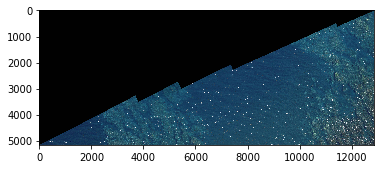

In [93]:
#we've got a cropped dataset.

show(dataset_cropped)

In [110]:
#now we got to find the intersection of the three band's masks and use that to mask the no remaining ndvs

#initializing the mask to '1', which appears to be an unset nodata value (ndv). However 1 could also be valid data. So we're going to have to
#get the logical union of all three bands' masks.

dataset_crop_mask = np.ma.masked_equal(dataset_cropped, 1)

In [125]:
np.ma.set_fill_value(dataset_crop_mask, 0)

In [127]:
dataset_filled = np.ma.filled(dataset_crop_mask)

In [130]:
dataset_mask_zeros = np.ma.masked_equal(dataset_filled, 0)

In [157]:
#we are taking the logical intersection of the masks, making two copies and arranging them into a 3-d structure that matches the shape of our cropped image

unified_mask = dataset_mask_zeros.mask[0] & dataset_mask_zeros.mask[1] & dataset_mask_zeros.mask[2]
unified_mask_2 = np.copy(unified_mask)
unified_mask_3 = np.copy(unified_mask)

unified_mask_3d = np.rollaxis(np.dstack((unified_mask, unified_mask_2, unified_mask_3)), 2, start=0)

In [158]:
#make sure the shapes match

unified_mask_3d.shape

(3, 5162, 12866)

In [159]:
dataset_cropped.shape

(3, 5162, 12866)

In [160]:
#export the final image

dataset_final = np.ma.array(dataset_cropped, mask=unified_mask_3d, fill_value=0)

In [161]:
profile=dataset.profile

profile.update(height = dataset_cropped.shape[1], 
               width = dataset_cropped.shape[2],
               nodata = 0,
               transform = dataset_cropped_transform) 

In [162]:
with rasterio.open(os.path.join(out_dir, 'kaho_102_crop_and_mask_rasterio.tif'), 'w', **profile) as dst:
    dst.write(np.ma.filled(dataset_final, 0).astype(rasterio.uint8))

In [ ]:
'''

RESULTS:

The script performs well. Unfortuantely there were tons of jaggen little artifacts around the edges that ranged in value from 0 to 20.
At this point I have to bail. I went with dans-gdal-tools, which is allowing me to clip a smooth edge with less coding.'''